In [5]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(0)

from scripts.reinforce_PPORLHF import reinforce_rwd2go_PPO_RLHF
from scripts.utils import pref_load

from scripts.model import getPolicy
import torch
import torch.nn.functional as F

from scripts.reinforce_PPORLHF import reinforce_rwd2go_PPO_RLHF

%load_ext autoreload
%autoreload 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cpu')

In [6]:
SEED=0
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

ENV_NAME = 'CartPole-v0'

env = gym.make(ENV_NAME)

K = 10

POLICY1_NAME = "policies/policy1.pth"
POLICY2_NAME = "policies/policy2_with_both.pth"
pref_data = pref_load(f"pref_data/pref_data_{K}_{ENV_NAME}.pickle")

/Users/guillaumevitalis/miniconda3/envs/RLA2Final/lib/python3.9/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/Users/guillaumevitalis/miniconda3/envs/RLA2Final/lib/python3.9/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/guillaumevitalis/miniconda3/envs/RLA2Final/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Epoch 1/20 — avg loss: 20.2496
Epoch 2/20 — avg loss: 17.9577
Epoch 3/20 — avg loss: 15.6575
Epoch 4/20 — avg loss: 13.3420
Epoch 5/20 — avg loss: 11.0079
Epoch 6/20 — avg loss: 8.6486
Epoch 7/20 — avg loss: 6.2628
Epoch 8/20 — avg loss: 3.8844
Epoch 9/20 — avg loss: 1.9938
Epoch 10/20 — avg loss: 1.3389
Epoch 11/20 — avg loss: 1.1759
Epoch 12/20 — avg loss: 1.0939
Epoch 13/20 — avg loss: 1.0097
Epoch 14/20 — avg loss: 0.9065
Epoch 15/20 — avg loss: 0.7836
Epoch 16/20 — avg loss: 0.6446
Epoch 17/20 — avg loss: 0.4951
Epoch 18/20 — avg loss: 0.3455
Epoch 19/20 — avg loss: 0.2116
Epoch 20/20 — avg loss: 0.1102


/var/folders/pw/zwdjqj615hv3p_c91lqpr_kc0000gn/T/ipykernel_67831/2295887200.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


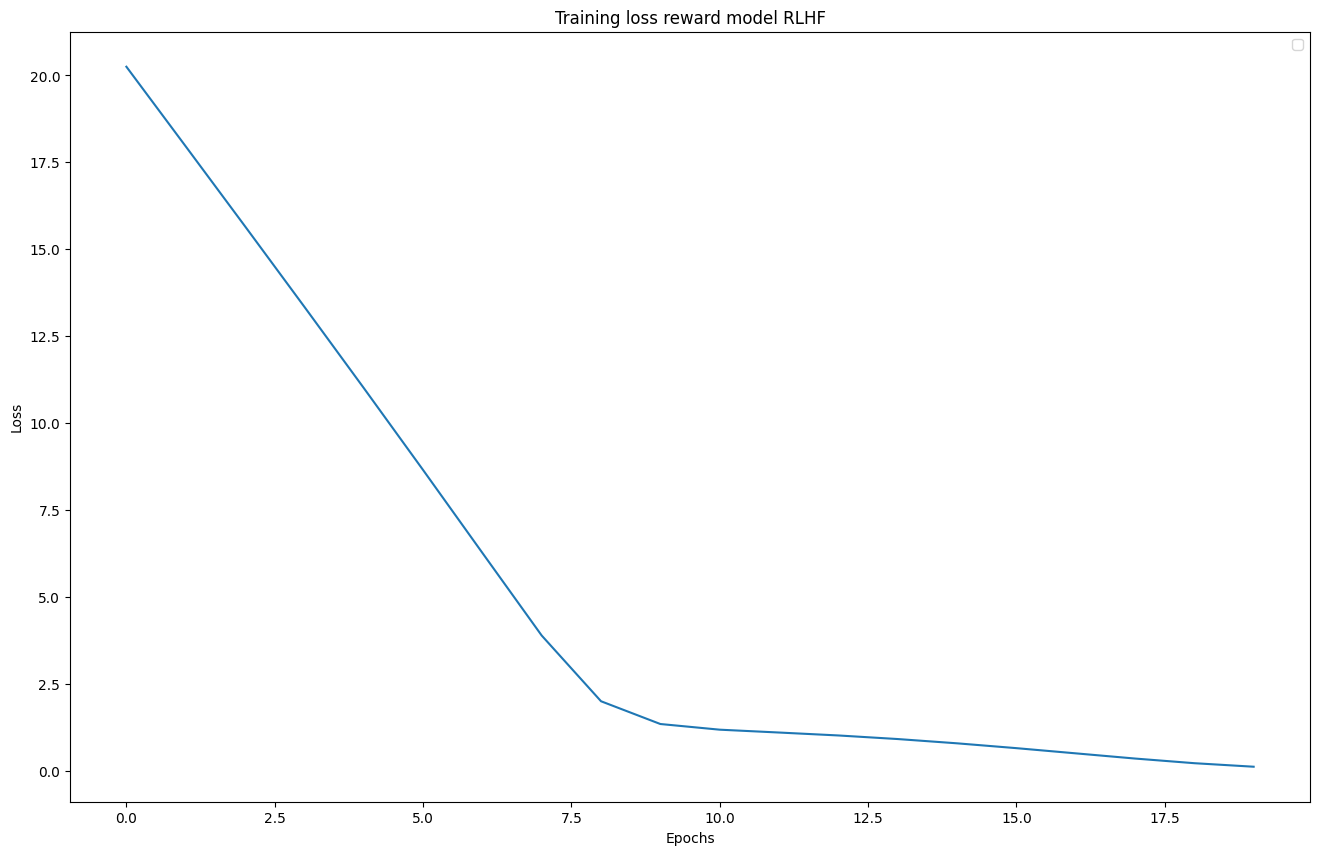

In [7]:
class RewardModel(nn.Module):
    def __init__(self, state_size=4, action_size=1, hidden_size=32):
        super(RewardModel, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return x

    def predict_reward(self, state, action):
        state = state
        action = torch.tensor(action).reshape(1,1)  
        
        state_action = torch.cat((state, action), dim=1)
        reward = self.forward(state_action).cpu()
        return reward
    

lr        = 3e-3
epochs    = 20

reward_model = RewardModel(state_size=4, action_size=1)

optimizer = torch.optim.Adam(reward_model.parameters(), lr=lr)

def trajectory_reward(reward_model, states, actions):
    total_reward = torch.tensor(0., device=device)
    for s, a in zip(states, actions):
        s_t = torch.tensor(s, dtype=torch.float32, device=device)
        reward = reward_model.predict_reward(s_t.unsqueeze(0), a).squeeze(0)
        total_reward += reward.squeeze(0)
    return total_reward

losses_reward_model = []
for epoch in range(1, epochs+1):
    total_loss = 0.0
    
    for s0, tau_plus, tau_minus in pref_data:

        reward_plus = trajectory_reward(reward_model, tau_plus["states"], tau_plus["actions"])
        reward_minus = trajectory_reward(reward_model, tau_minus["states"], tau_minus["actions"])
        total_loss += - torch.log(torch.exp(reward_plus) / (torch.exp(reward_minus) + torch.exp(reward_plus)))

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    avg_loss = total_loss / len(pref_data)
    losses_reward_model.append(avg_loss.detach().numpy().item())
    
    print(f"Epoch {epoch}/{epochs} — avg loss: {avg_loss:.4f}")

plt.plot(np.arange(epochs), losses_reward_model)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training loss reward model RLHF")
plt.legend()
plt.savefig(f"RLHF_{ENV_NAME}_{K}.jpg")
plt.show()

/Users/guillaumevitalis/miniconda3/envs/RLA2Final/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Ep 100	avg100: 125.93
Ep 200	avg100: 152.74
Ep 300	avg100: 161.36
Ep 400	avg100: 169.06
Ep 500	avg100: 162.15
Ep 600	avg100: 166.64
Ep 700	avg100: 178.72
Ep 800	avg100: 175.20
Ep 900	avg100: 178.79
Ep 1000	avg100: 185.33
Ep 1100	avg100: 173.81
Ep 1200	avg100: 180.30
Ep 1300	avg100: 191.22
Ep 1400	avg100: 183.35
Ep 1500	avg100: 181.21
Ep 1600	avg100: 190.71
Ep 1700	avg100: 179.51
Ep 1800	avg100: 185.06
Ep 1900	avg100: 191.04


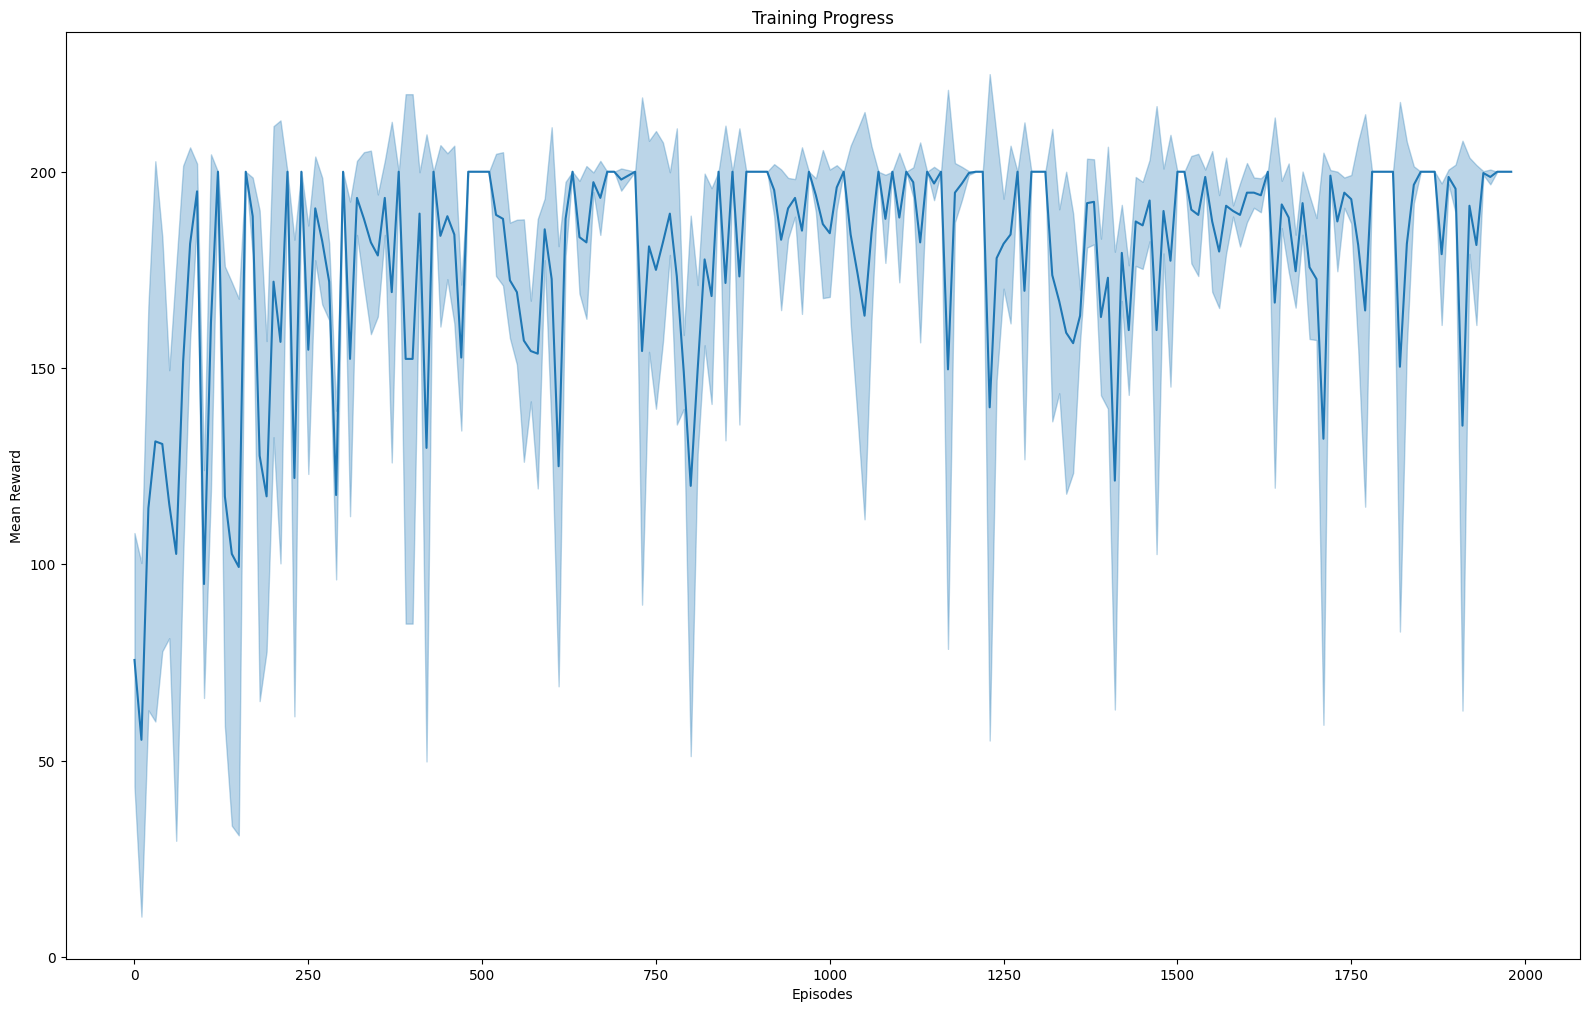

In [8]:
policy2 = getPolicy(ENV_NAME=ENV_NAME).to(device)
policy2.load_state_dict(torch.load(POLICY2_NAME))


opt1 = optim.Adam(policy2.parameters(), lr=1e-3)
reward_model.eval()

reward_evaluation_every=10
losses, mean_returns, std_returns = reinforce_rwd2go_PPO_RLHF(env, policy2, opt1, reward_model, n_episodes=2000, reward_evaluation_every=reward_evaluation_every);

x = np.arange(len(losses)) * reward_evaluation_every
plt.plot(x, mean_returns, color="tab:blue", label="Mean Reward")
plt.fill_between(x, mean_returns - std_returns, mean_returns + std_returns, color="tab:blue", alpha=0.3)
plt.ylabel("Mean Reward")
plt.xlabel("Episodes")

plt.tight_layout()
plt.title("Training Progress")
plt.savefig(f"Mean_reward_RLHF_{ENV_NAME}_{K}.jpg")
plt.show()